In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tanzanian Water Pumps
A priori knowledge about the project:

* Client: Tanzanian Ministry of Water
* Top priority: access to clean water for the whole population
* Dataset: Containing data regarding samples of all water pumps
* 3 Labels: functional, functional needs repair, non functional
* Features such as location, water quality, construction year, etc.
* Feature description: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/

Data Import

In [3]:
feature_filename = "data/Features.csv"
label_filename = "data/Labels.csv"
df_feat = pd.read_csv(feature_filename)
df_label = pd.read_csv(label_filename)
df = pd.merge(df_feat, df_label, on='id', how='inner')

In [20]:
# reorder classes to make sure they appear in the right order in the plots
df['status_group'] = pd.Categorical(df['status_group'], ['functional','functional needs repair','non functional'])

# Data Understanding
In this notebook, I will try to understand the target label and the numerical features better. I will deal with the categorical features in another notebook (data_understanding2) for better readability.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Very high number of null values for the scheme_name attribute. Description: scheme_name - Who operates the waterpoint
Decision: Drop scheme_name feature from dataset

<AxesSubplot: >

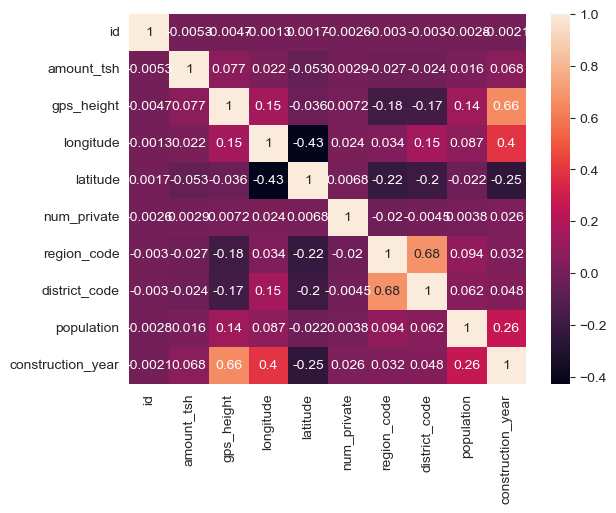

In [5]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

* High correlation between gps_height and construction_year.
* High correlation between region_code and district_code.
* Relatively high correlation between longitude and construction year.
* Surprisingly: low correlation between coordinates (longitude, latitude) and region_code and district_code

Note that these low/high correlations may exist due to poor data quality.

## Label

In [6]:
df["status_group"].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

The classes are not equally distributed. Training on this dataset could potentially harm the accuracy of the model.

# Numerical Features

In [7]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


* amount_tsh - Total static head (amount water available to waterpoint): seems to be containing outliers
* gps_height: 25%-quantile = 0 is suspicious, might be indicating missing values
* longitude: Min. value 0.000 is looking suspicious. Need to investigate further.
* latitude: No values greater as or equal to 0
* num_private: no feature description available and seems to be containing outliers as well -> drop feature
* population: seems to contain outliers; 0-values need to be investigated.
* construction_year: 0-values need to be addressed

## amount_tsh - Total static head (amount water available to waterpoint)


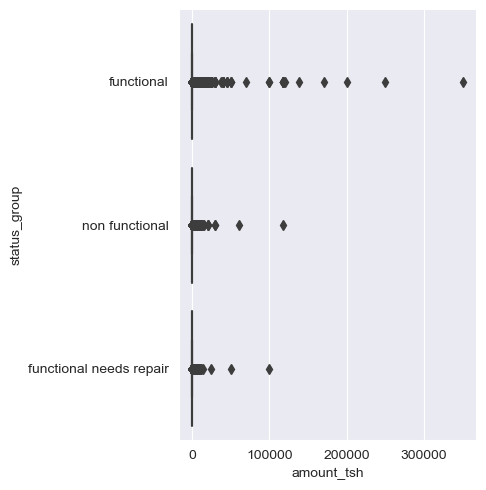

In [8]:
sns.catplot(data=df, x="amount_tsh", y="status_group", kind="box")

Outliers exist for all labels.

* Explanation of the feature: https://www.pumpfundamentals.com/what%20is%20head.htm
* Typical depth of water pumps: https://homeguides.sfgate.com/depth-guide-water-pump-103317.html

Decision: Remove outliers (>120) and impute missing values (0's) with median

## population & gps_height

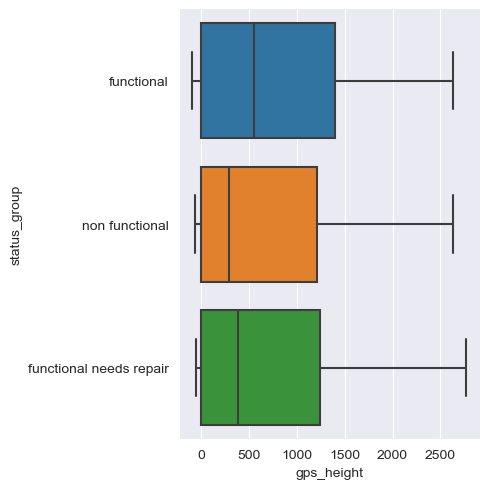

gps_height
 1     3907
3     3445
2     2913
4     2864
6     2444
5     1580
7     1551
8     1017
30     669
0       23
80      12
53       7
62       3
43       2
23       1
Name: district_code, dtype: int64
gps_height
 1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
53      745
43      505
23      293
62      109
0        23
80       12
Name: district_code, dtype: int64
Label distribution of gps_height
 functional                 10469
non functional              8206
functional needs repair     1763
Name: status_group, dtype: int64


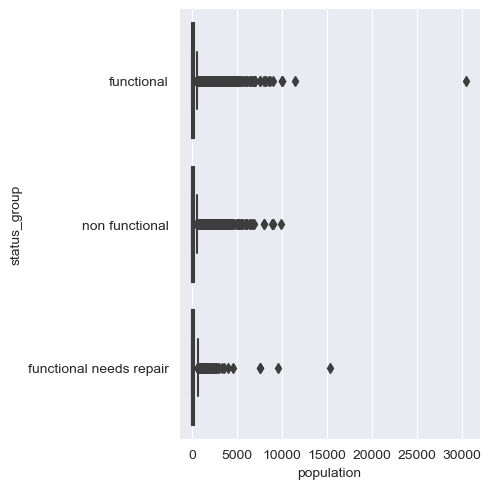

population
 3     4075
2     3804
1     3618
4     3000
6     2444
5     1582
7     1424
8      729
30     669
0       23
80      12
53       1
Name: district_code, dtype: int64
population
 1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
53      745
0        23
80       12
Name: district_code, dtype: int64
Label distribution of population
 functional                 11274
non functional              8332
functional needs repair     1775
Name: status_group, dtype: int64


In [9]:
for att in ["gps_height", "population"]:
    sns.catplot(data=df, x=att, y="status_group", kind="box")
    plt.show()

    rc0 = df[df[att] == 0]["district_code"]
    print(f"{att}\n", rc0.value_counts())  # print number of instances with 0 population per district_code

    # print TOTAL number of instances (any #pop) for those district_code that have instances with 0 pop
    print(f"{att}\n", df[df["district_code"].isin(rc0)]["district_code"].value_counts())

    print(f"Label distribution of {att}\n", df[df[att] == 0]["status_group"].value_counts())

We can observe many missing values(0's) for both features.
However, there are too many instances with 0 gps_height/pop to justify removing the instances from the dataset. Therefore:
Decision: Impute 0's of gps_height/pop features with median value of instances per district_code.


In [10]:
df[df["population"] > 10000]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
14308,49354,0.0,2013-02-21,Water Board,1084,Water board,36.386050,-4.787678,Mashineni,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional needs repair
30537,12169,0.0,2011-03-12,Government Of Tanzania,184,DWE,38.783756,-5.181904,Mkwajuni,0,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
51398,30750,50.0,2011-03-04,Wsdp,26,DWE,38.727663,-6.724701,Msagasa,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional


Only three instances with a population value of over 10000. In all three cases the water pumps are still functional.
Decision: remove heavy outliers (pop >10000)

## Longitude/Latitude

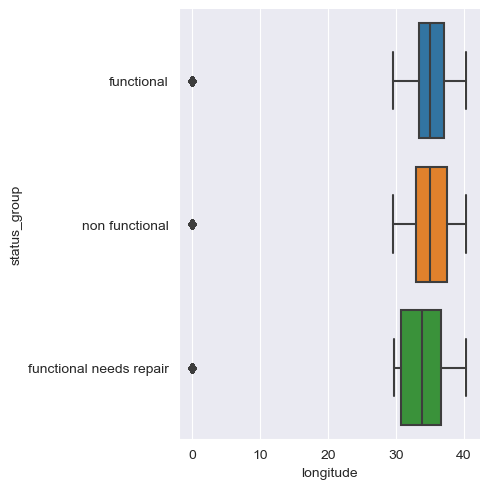

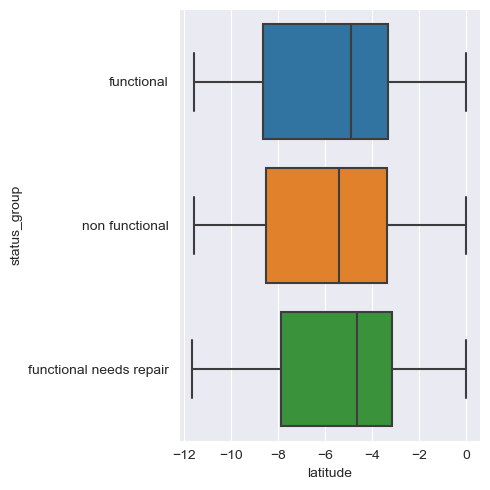

In [11]:
for att in ["longitude", "latitude"]:
    sns.catplot(data=df, x=att, y="status_group", kind="box")
    plt.show()

In [12]:
df[df["longitude"] == 0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,...,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,0,DWE,0.0,-2.000000e-08,Wazazo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,0,DWE,0.0,-2.000000e-08,Mtakuja,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,0,DWE,0.0,-2.000000e-08,Maendeleo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.0,-2.000000e-08,Mwazwilo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


It is worth noting that the missing values in the latitude feature seem to be stored as -2.000000e-8 (almost zero)

In [13]:
df[df["latitude"] == -2.000000e-08]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,...,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,0,DWE,0.0,-2.000000e-08,Wazazo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,0,DWE,0.0,-2.000000e-08,Mtakuja,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,0,DWE,0.0,-2.000000e-08,Maendeleo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.0,-2.000000e-08,Mwazwilo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


We can clearly observe missing values for both coordinates.
Decision: Impute with median value of the corresponding district_code

## Construction_year

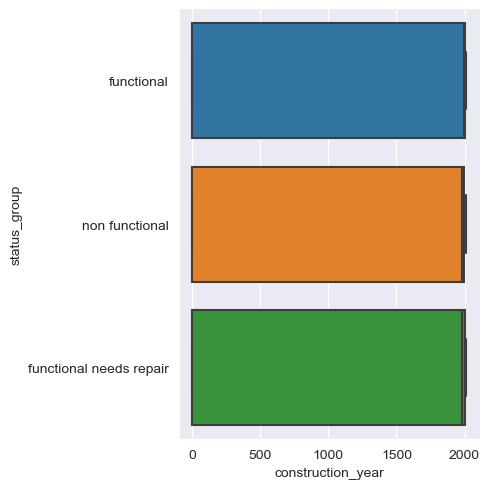

In [14]:
sns.catplot(data=df, x="construction_year", y="status_group", kind="box")

Boxplots indicate bad data quality. Look at missing values:

In [15]:
df[df["construction_year"]==0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,...,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,...,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59384,72148,0.0,2011-07-10,Concern,0,CONCERN,30.667805,-2.483710,Chamkube,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
59392,40607,0.0,2011-04-15,Government Of Tanzania,0,Government,33.009440,-8.520888,Benard Charles,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
59393,48348,0.0,2012-10-27,Private,0,Private,33.866852,-4.287410,Kwa Peter,0,...,soft,good,insufficient,insufficient,dam,dam,surface,other,other,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional


Note: High number of missing values (0's) for construction year.

C:\Users\phili\anaconda3\envs\sia_env3.8\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='Count', ylabel='construction_year'>

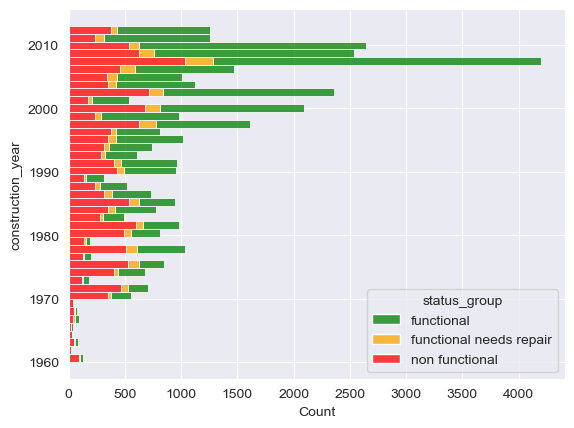

In [27]:
sns.histplot(data=df[df["construction_year"] > 0], y="construction_year", hue="status_group", multiple="stack", palette=["g", "orange", "r"])

As expected, we can clearly see that for older water pumps are more likely to be non functional

<AxesSubplot: >

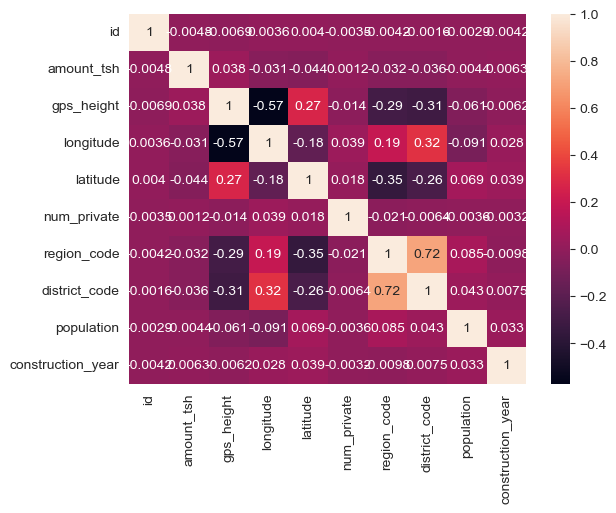

In [17]:
sns.heatmap(df[df["construction_year"] != 0].corr(numeric_only=True), annot=True)

Almost no correlation to any other numerical feature. Decision: Impute with median value of column.